## Feature Engineering 

In [309]:
import numpy as np
import pandas as pd
from scipy import stats
import modules.help_functions as hf
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import PolynomialFeatures

from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import RFE

import pickle

from sklearn.pipeline import make_pipeline
import matplotlib.pyplot as plt

In [333]:
# read in file
df = pd.read_csv('../data/flights.csv')
df_delays = hf.get_avg_delay(df, ['carrier_delay', 'weather_delay', 'nas_delay', 'security_delay', 'late_aircraft_delay'])

In [334]:
def convert_testtrain_data_to_test_format(df):
    """ Convert our testing data to be in the same format as the data to test (drop columns and reformat date)"""
    
    #convert date to datetime with 0's
    df.fl_date = (df.fl_date + ' 00:00:00')
    pd.to_datetime(df['fl_date'])
    
    #drop columns not present in test format
    df.drop(columns=['dep_time',
       'dep_delay', 'taxi_out', 'wheels_off', 'wheels_on', 'taxi_in', 'arr_time', 'cancelled',
       'cancellation_code', 'diverted', 'actual_elapsed_time', 'air_time', 
       'carrier_delay', 'weather_delay', 'nas_delay', 'security_delay',
       'late_aircraft_delay', 'first_dep_time', 'total_add_gtime',
       'longest_add_gtime','no_name'], inplace = True)
    return df


In [335]:
def convert_from_test_format_to_fit_predict_format(df):
    """Adds in columns for model fitting and converts to numeric/ encoded categorical for ML model"""
    
    # Split crs_arr_time and crs_dep_time into hour of day (local)
    df = hf.split_time_of_day_departure(df)
    df = hf.split_time_of_day_arrival(df)
    df.drop(columns=['crs_dep_time', 'crs_arr_time'], inplace=True)
    
    #take log distance
    df['distance_log'] = np.log(df.distance)
    df.drop(columns=['distance'], inplace=True)
    
    # encode hour of day departure
    f = lambda x: str(int(np.floor(x)))
    df['dep_hour'] = df['dep_hour'].apply(f)
    df['arr_hour'] = df['arr_hour'].apply(f)
    df = hf.encode_and_bind(df, 'dep_hour')
    df = hf.encode_and_bind(df, 'arr_hour')
 
    # Convert fl_date into day of week  # NOTE MAY WANT TO ADD BACK IN MONTH OR JAN 1 days
    df = hf.add_weekday(df)
    df.drop(columns=['fl_date'], inplace=True)
    df = hf.encode_and_bind(df, 'weekday')
    
    # Add average delays to dest
    df = df.merge(df_delays, on='dest', how='left')
    
    # Split city and state 
    hf.split_origin_city_state(df)
    hf.split_dest_city_state(df)
    df.drop(columns=['dest_city_name', 'origin_city_name'], inplace=True)
    
    # Encode top 10 cities in terms of traffic
#     df = hf.make_col_value_qbins(df, 'origin_city', 'origin_city_bin', 10)
#     df = hf.make_col_value_qbins(df, 'dest_city', 'dest_city_bin', 10)
    
    city_list = ['Chicago','Atlanta','New York','Dallas/Fort Worth','Denver','Charlotte','Houston','Washington','Los Angeles','Seattle']    
    df.dest_city = np.where(df.dest_city.isin(city_list),df.dest_city, '0')
    df.origin_city = np.where(df.origin_city.isin(city_list),df.origin_city, '0')
    df = hf.encode_and_bind(df, 'origin_city')
    df = hf.encode_and_bind(df, 'dest_city')
    df.drop(columns=['dest_city', 'origin_city'], inplace=True)
    
    #Top 20 airport codes
    # DOES AIRPORT TRAFFIC CORRELATED WITH ARR_DELAY?
#     df = hf.make_col_value_qbins(df, 'origin', 'origin_bin', 15)
#     df = hf.make_col_value_qbins(df, 'dest', 'dest_bin', 15)

    top20_airport_code = ['LAX', 'ORD', 'EWR', 'SFO', 'LGA', 'DFW', 'LAS', 'CLT', 'DEN',
                      'PHL', 'IAH', 'SEA', 'ATL', 'PHX', 'MCO', 'DTW', 'SLC', 'BOS',
                      'JFK', 'MSP']
    df.dest = np.where(df.dest.isin(top20_airport_code),df.dest, '0')
    df.origin = np.where(df.origin.isin(top20_airport_code),df.origin, '0')
    df = hf.encode_and_bind(df, 'dest')
    df = hf.encode_and_bind(df, 'origin')
    
    #REMOVE negative targets (arr_delay - set to zero)
#     df.arr_delay = np.where(df.arr_delay >0,df.arr_delay, 0)
    
    # State - Encode (based on # flights)
    # DOES NUMBER OF FLIGHTS IN STATE CORRELATED WITH ARR_DELAY?
    state_list = ['CA','TX', 'FL', 'IL', 'NY', 'GA', 'NC', 'CO', 'PA', 'WA']

#     df = hf.make_col_value_qbins(df, 'origin_state', 'origin_state_bin', 15)
#     df = hf.make_col_value_qbins(df, 'dest_state', 'dest_state_bin', 15)
    df.dest_state = np.where(df.dest_state.isin(state_list),df.dest_state, '0')
    df.origin_state = np.where(df.origin_state.isin(state_list),df.origin_state, '0')
    df = hf.encode_and_bind(df, 'origin_state')
    df = hf.encode_and_bind(df, 'dest_state')
    df.drop(columns=['dest_state', 'origin_state'], inplace=True)
          
    # Convert Airline Carrier - Encode 
    df = hf.encode_and_bind(df, 'mkt_unique_carrier')
    df.drop(columns = ['mkt_unique_carrier'], inplace=True)

    # Origin Airport - Encode top 10 (rest in 'other') OR BIN according to passenger or flight volume
    df = hf.make_col_value_bins(df, 'origin', 'origin_airport_fl_amt_bin', 7) 
    
    
    # Dest Airport - Encode top 10 or bin according to passenger of flight volume 
    df = hf.make_col_value_bins(df, 'dest', 'dest_airport_fl_amt_bin', 7) 
   
    # Flight number ??? # drop for now? 
    df.drop(columns = ['mkt_carrier_fl_num'], inplace=True)
    
    # crs_elapsed # USE LONG HAUL SHORT HAUL
    df['log_crs_elapsed_time'] = np.log(df.crs_elapsed_time)
    df = hf.make_bin_column(df, 'log_crs_elapsed_time', 20) # 8-2/0.3
    # crs_elapsed # USE LONG HAUL SHORT HAUL
    df['log_crs_elapsed_time'] = np.log(df.crs_elapsed_time)
    df = hf.make_bin_column(df, 'log_crs_elapsed_time', 10) # 8-2/0.3
    df.log_crs_elapsed_time_bin = df.log_crs_elapsed_time_bin.replace({1:'a', 2: 'b',3:'c',4:'d', 5:'e', 6:'f', 7:'g',8:'h', 9:'i', 10:'j'}) 
    df = hf.encode_and_bind(df, 'log_crs_elapsed_time_bin')
    df.drop(columns = ['crs_elapsed_time','log_crs_elapsed_time', 'log_crs_elapsed_time_bin' ], inplace=True)

    # Drop rest
    df.drop(columns=['branded_code_share', 'mkt_carrier','op_unique_carrier', 'tail_num', 
                     'op_carrier_fl_num', 'dep_hour', 'origin_airport_id', 'arr_hour','dest_airport_id',  'dup', 'flights'], errors='ignore', inplace = True)


    return df

In [336]:
def load_preprocessed_data():
    """ read in data file, convert to the format the given test data is in and add / format columns per feature engineering """
   
    df = pd.read_csv('../data/flights.csv')
    
    # remove non-landing flights
    df.dropna(subset=['arr_delay'], inplace=True)
    
#     remove outliers ### IS THIS GOING TO BACKFIRE?
#     df_rm = df_rm[(np.abs(stats.zscore(df_rm['arr_delay'])) < 3)]
    cols = ['arr_delay'] 
    Q1 = df[cols].quantile(0.25)
    Q3 = df[cols].quantile(0.75)
    IQR = Q3 - Q1
    df = df[~((df[cols] < (Q1 - 1.5 * IQR)) |(df[cols] > (Q3 + 1.5 * IQR))).any(axis=1)]
    
    # convert
    df = convert_testtrain_data_to_test_format(df)
    df = convert_from_test_format_to_fit_predict_format(df)
    return df

In [337]:
df = load_preprocessed_data()

### Scale

In [95]:
# list(df.columns)

In [338]:
# rescale the features
# scaler = MinMaxScaler()
scaler = StandardScaler()

# apply scaler() to all the numeric columns 
numeric_vars = ['avg_carrier_delay', 
                 'avg_weather_delay', 
                 'avg_nas_delay', 
                 'avg_security_delay', 
                 'avg_late_aircraft_delay', 'distance_log'
                 ]
df[numeric_vars] = scaler.fit_transform(df[numeric_vars])
# list(df.columns)

### Remove Highly Correlated Features and small Variance

In [339]:
 def remove_small_variance(x, variance_threshold = 0.1):
    # Assumptions - target variable removed, df is numeric
    # import:
    # from sklearn.feature_selection import VarianceThreshold
    vt = VarianceThreshold(variance_threshold)
    x_transformed = vt.fit_transform(x)
    selected_columns = x.columns[vt.get_support()]
    x_transformed = pd.DataFrame(x_transformed, columns = selected_columns)
    return(x_transformed)

In [340]:
def remove_highly_correlated_features(df, correlation_threshold=0.8):
    #     Anything above correlation threshold will be tossed
    # Assumptions - all numeric, target variable removed
    # step 1
    df_corr = df.corr().abs()

    # step 2
    indices = np.where(df_corr > correlation_threshold)
    indices = [(df_corr.index[x], df_corr.columns[y])
    for x, y in zip(*indices)
        if x != y and x < y]

    # step 3
    for idx in indices: #each pair
        try:
            df.drop(idx[1], axis = 1, inplace=True)
        except KeyError:
            pass
    return(df)



#### Linear Regression

In [341]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
y = df.arr_delay.to_numpy()
X = df.drop(columns=['arr_delay']).to_numpy()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=88)

lr_baseline = LinearRegression()
lr_baseline.fit(X_train, y_train)

# Save pickle file
# model = lr_baseline
# filename = '../model/linear_regression_all_features_except_neg_target.pkl'
# pickle.dump(model, open(filename, 'wb'))


y_pred = lr_baseline.predict(X_test)

r2_baseline = r2_score(y_test, y_pred)
MSE_baseline = mean_squared_error(y_test,y_pred) 
RMSE_baseline = mean_squared_error(y_test,y_pred,squared=False)
MAE_baseline = mean_absolute_error(y_test,y_pred)

print(f' r2: {r2_baseline}\n MSE: {MSE_baseline}\n MAE: {MAE_baseline}\n model_fit {r2_baseline}')

C:\Users\jacky\anaconda3\envs\bootcamp\lib\site-packages\sklearn\utils\validation.py:956: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  X = check_array(
C:\Users\jacky\anaconda3\envs\bootcamp\lib\site-packages\sklearn\base.py:557: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  X = check_array(X, **check_params)


 r2: 0.07423107459919531
 MSE: 272.3595647481022
 MAE: 12.85724161223855
 model_fit 0.07423107459919531


### Lasso

In [319]:
# Grid search for Lasso
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Lasso, Ridge
from sklearn.metrics import mean_squared_error, r2_score
y = df.arr_delay.to_numpy()
X = df.drop(columns=['arr_delay']).to_numpy()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

lr = Lasso()
params = {'alpha': np.arange(0.1, 0.3, 0.01)}
gs_lasso = GridSearchCV(lr, param_grid=params, cv=5, n_jobs=-1)
gs_lasso.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=Lasso(), n_jobs=-1,
             param_grid={'alpha': array([0.1 , 0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 ,
       0.21, 0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29])})

In [322]:
gs_lasso.best_params_, gs_lasso.best_score_

({'alpha': 0.1}, 0.039387931896349836)

In [109]:
gs_lasso.best_params_, gs_lasso.best_score_

({'alpha': 0.1}, 0.0424644632677655)

In [323]:
# create the model
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error, r2_score
y = df.arr_delay.to_numpy()
X = df.drop(columns=['arr_delay']).to_numpy()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

lr = Lasso(alpha=0.001, max_iter=2000)
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)
print(f'MSE: {mean_squared_error(y_test, y_pred)}', f'R2: {r2_score(y_test, y_pred)}')

C:\Users\jacky\anaconda3\envs\bootcamp\lib\site-packages\sklearn\base.py:557: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  X = check_array(X, **check_params)


MSE: 274.96746142721105 R2: 0.06420325018031958


In [324]:
lr_coeff = pd.DataFrame(data={'feature':X.columns.tolist(), 'coeff':lr.coef_})

In [326]:
lr_coeff[df_coeff.coeff == 0]

<ipython-input-326-013c309d8eb8>:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  lr_coeff[df_coeff.coeff == 0]


,feature,coeff
2,weekday_0,0.000000
12,avg_security_delay,0.032615
13,avg_late_aircraft_delay,0.153493
14,origin_city_0,-2.645503
37,dest_ATL,0.000000
42,dest_DTW,-0.060952
48,dest_LGA,-4.770523
51,dest_ORD,-0.803531
57,origin_0,0.000000
71,origin_MSP,-6.198259


In [327]:
list(df.columns)

['arr_delay',
 'distance_log',
 'weekday',
 'weekday_0',
 'weekday_1',
 'weekday_2',
 'weekday_3',
 'weekday_4',
 'weekday_5',
 'weekday_6',
 'avg_carrier_delay',
 'avg_weather_delay',
 'avg_nas_delay',
 'avg_security_delay',
 'avg_late_aircraft_delay',
 'origin_city_0',
 'origin_city_Atlanta',
 'origin_city_Charlotte',
 'origin_city_Chicago',
 'origin_city_Dallas/Fort Worth',
 'origin_city_Denver',
 'origin_city_Houston',
 'origin_city_Los Angeles',
 'origin_city_New York',
 'origin_city_Seattle',
 'origin_city_Washington',
 'dest_city_0',
 'dest_city_Atlanta',
 'dest_city_Charlotte',
 'dest_city_Chicago',
 'dest_city_Dallas/Fort Worth',
 'dest_city_Denver',
 'dest_city_Houston',
 'dest_city_Los Angeles',
 'dest_city_New York',
 'dest_city_Seattle',
 'dest_city_Washington',
 'dest_0',
 'dest_ATL',
 'dest_BOS',
 'dest_CLT',
 'dest_DEN',
 'dest_DFW',
 'dest_DTW',
 'dest_EWR',
 'dest_IAH',
 'dest_JFK',
 'dest_LAS',
 'dest_LAX',
 'dest_LGA',
 'dest_MCO',
 'dest_MSP',
 'dest_ORD',
 'dest_P

### Ridge

In [98]:
# Grid Search for Ridge
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Lasso, Ridge
from sklearn.metrics import mean_squared_error, r2_score

y = df.arr_delay.to_numpy()
X = df.drop(columns=['arr_delay']).to_numpy()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

rr = Ridge()
params = {'alpha': np.arange(0.001, 0.1, 0.01)}
gs_ridge = GridSearchCV(rr, param_grid=params, cv=5, n_jobs=-1)
gs_ridge.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=Ridge(), n_jobs=-1,
             param_grid={'alpha': array([0.001, 0.011, 0.021, 0.031, 0.041, 0.051, 0.061, 0.071, 0.081,
       0.091])})

In [83]:
gs_ridge.best_params_

{'alpha': 0.49}

In [94]:
gs_ridge.best_score_

0.07322351348448844

In [97]:
gs_ridge.best_params_, gs_ridge.best_score_

({'alpha': 0.6900000000000002}, 0.07322246866107178)

In [99]:
gs_ridge.best_params_, gs_ridge.best_score_

({'alpha': 0.09099999999999998}, 0.07327123466059556)

In [329]:
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, r2_score

y = df.arr_delay.to_numpy()
X = df.drop(columns=['arr_delay']).to_numpy()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

rr = Ridge(alpha=0.09)
rr.fit(X_train, y_train)
y_pred = rr.predict(X_test)
print(f'MSE: {mean_squared_error(y_test, y_pred)}', f'R2: {r2_score(y_test, y_pred)}')

C:\Users\jacky\anaconda3\envs\bootcamp\lib\site-packages\sklearn\base.py:557: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  X = check_array(X, **check_params)


MSE: 277.33621523977234 R2: 0.061400392980568874


In [121]:
rr.coef_

array([ 3.08270912e+00, -2.05525393e+00, -1.88646538e+00, -2.85367693e-01,
       -5.83085293e-02,  1.43494588e-01,  2.80688016e-01,  2.23515396e-01,
       -2.75292441e-01, -3.88367825e-02,  2.16630739e-01,  2.84691886e-01,
       -3.25039483e-01, -9.31384672e-01, -3.47247217e-01,  5.85643981e-01,
       -4.18504168e-01,  5.87447153e-02,  7.85361178e+00,  7.10973049e+00,
       -3.10080872e+00, -2.94137489e+00, -2.13540117e+00, -1.01966673e+00,
       -9.37799086e-01,  2.23859927e+00,  5.65807329e+00, -9.45068832e-01,
       -1.01908564e+00, -1.48321223e+00, -1.24050464e+00, -8.22436913e-01,
       -1.07953222e+00, -3.86867970e-01,  3.47623498e-01,  8.55180516e-01,
        7.39498613e-01,  1.12213158e-01,  9.77468058e-01,  6.80069156e-01,
        5.71168424e-01,  6.49336130e-01, -1.02764589e-01,  3.32645978e+00,
       -2.71089736e+00, -1.73455330e+00, -1.35077993e+00, -1.40091909e+00,
       -7.31210972e-01, -1.14785564e+00,  1.81212023e-01,  3.80463245e-01,
       -1.23771820e+00, -

In [122]:
rr_coeff = pd.DataFrame(data={'feature':X.columns.tolist(), 'coeff':rr.coef_})

In [131]:
threshold = 0.2
rr_coeff[np.abs(rr_coeff.coeff) < threshold]

,feature,coeff
4,dep_hour_11,-0.058309
5,dep_hour_12,0.143495
9,dep_hour_16,-0.038837
17,dep_hour_23,0.058745
37,arr_hour_2,0.112213
42,arr_hour_24,-0.102765
50,weekday,0.181212
53,weekday_2,-0.000395
58,avg_carrier_delay,0.107198
59,avg_weather_delay,0.001235


### LDA analysis

In [187]:
y = df.arr_delay
X = df.drop(columns=['arr_delay'])

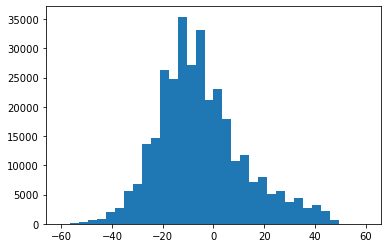

In [188]:
plt.hist(y, bins=np.linspace(-60, 60, 35));

In [190]:
labels = np.arange(1, 36, 1)
y = pd.qcut(y, q=36, duplicates='drop', labels=labels)

In [191]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import mean_squared_error, r2_score

y = df.arr_delay
X = df.drop(columns=['arr_delay'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

lda = LinearDiscriminantAnalysis()
lda.fit(X_train, y_train)

LinearDiscriminantAnalysis()

In [193]:
lda.explained_variance_ratio_

array([0.65164704, 0.16550048, 0.07236323, 0.0175777 , 0.01043113,
       0.00589833, 0.00566196, 0.00489947, 0.00456412, 0.00431464,
       0.00417148, 0.00399047, 0.0038059 , 0.00364057, 0.00347665,
       0.00326825, 0.0032009 , 0.0028574 , 0.00276812, 0.0026184 ,
       0.00242478, 0.00227058, 0.00224553, 0.00216911, 0.00195257,
       0.00184915, 0.00173507, 0.00150957, 0.00139335, 0.00132268,
       0.00120594, 0.00118131, 0.0010962 , 0.00098795])

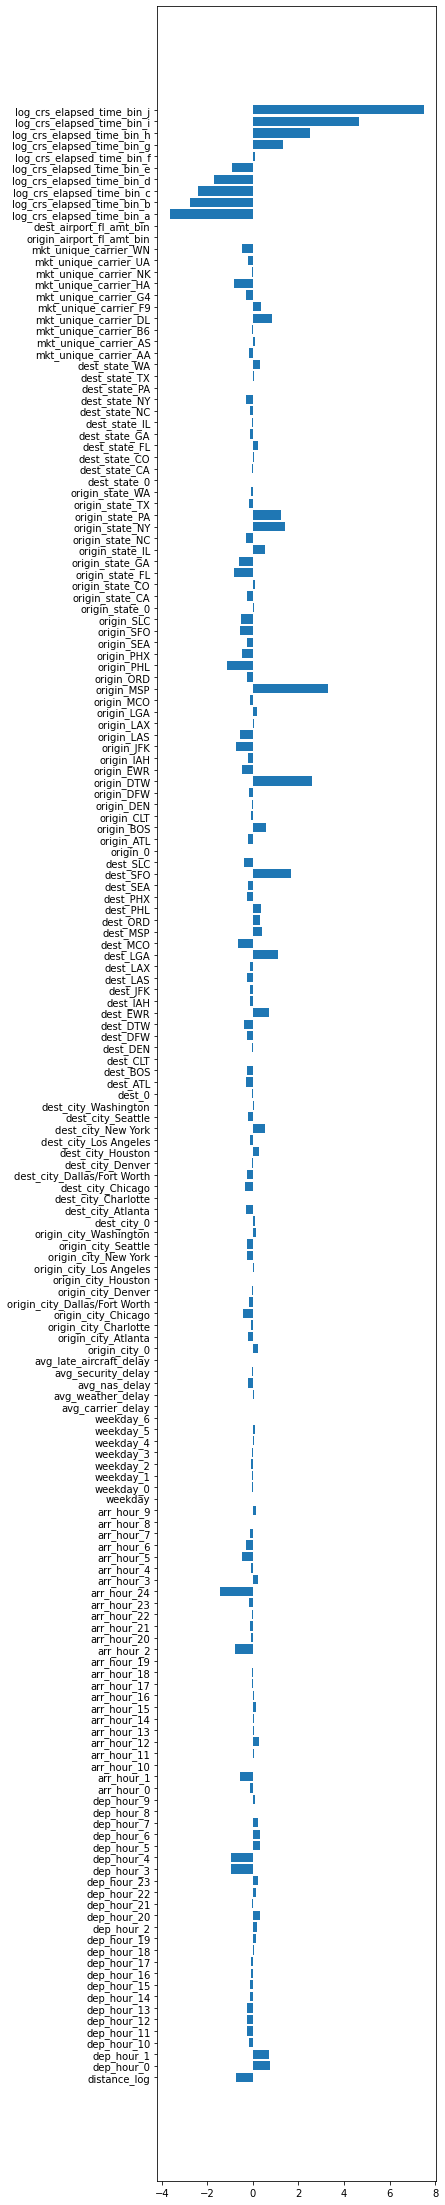

In [284]:
plt.figure(figsize=(5, 40))
plt.barh(y=X.columns, width=lda.coef_[0]);

### Feature Selection

In [209]:
y = df.arr_delay
X = df.drop(columns=['arr_delay'])

In [198]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

In [223]:
y = df.arr_delay.to_numpy()
X = df.drop(columns=['arr_delay']).to_numpy()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

# Feature extraction

test = SelectKBest(k=5)
test.fit(X_train, y_train)

# Set precision
np.set_printoptions(precision=3)



C:\Users\jacky\anaconda3\envs\bootcamp\lib\site-packages\sklearn\utils\validation.py:956: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  X = check_array(


In [225]:
df_kbest = pd.DataFrame(data={'feature':X.columns, 'score':test.scores_})

In [255]:
df_kbest[df_kbest.score < 1.3]

,feature,score
1,dep_hour_0,1.081689
2,dep_hour_1,0.938924
3,dep_hour_10,0.932629
5,dep_hour_12,1.167193
6,dep_hour_13,1.285651
18,dep_hour_3,1.118276
19,dep_hour_4,0.895625
31,arr_hour_14,1.256504
32,arr_hour_15,1.156937
33,arr_hour_16,1.157165


In [262]:
# Import your necessary dependencies
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression

y = df.arr_delay.to_numpy()
X = df.drop(columns=['arr_delay']).to_numpy()

model = LinearRegression()
rfe = RFE(model, n_features_to_select=0.7, verbose=True)
rfe.fit(X_train, y_train)
print("Num Features: %s" % (fit.n_features_))
print("Selected Features: %s" % (fit.support_))
print("Feature Ranking: %s" % (fit.ranking_))

C:\Users\jacky\anaconda3\envs\bootcamp\lib\site-packages\sklearn\utils\validation.py:956: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  X = check_array(


Fitting estimator with 171 features.
Fitting estimator with 170 features.
Fitting estimator with 169 features.
Fitting estimator with 168 features.
Fitting estimator with 167 features.
Fitting estimator with 166 features.
Fitting estimator with 165 features.
Fitting estimator with 164 features.
Fitting estimator with 163 features.
Fitting estimator with 162 features.
Fitting estimator with 161 features.
Fitting estimator with 160 features.
Fitting estimator with 159 features.
Fitting estimator with 158 features.
Fitting estimator with 157 features.
Fitting estimator with 156 features.
Fitting estimator with 155 features.
Fitting estimator with 154 features.
Fitting estimator with 153 features.
Fitting estimator with 152 features.
Fitting estimator with 151 features.
Fitting estimator with 150 features.
Fitting estimator with 149 features.
Fitting estimator with 148 features.
Fitting estimator with 147 features.
Fitting estimator with 146 features.
Fitting estimator with 145 features.
F

In [263]:
X.columns[~fit.support_]

Index(['distance_log', 'dep_hour_1', 'dep_hour_19', 'dep_hour_20',
       'dep_hour_5', 'dep_hour_6', 'dep_hour_7', 'weekday',
       'avg_carrier_delay', 'avg_weather_delay', 'avg_nas_delay',
       'avg_security_delay', 'avg_late_aircraft_delay', 'origin_city_0',
       'origin_city_Chicago', 'origin_city_Houston', 'origin_city_Seattle',
       'origin_city_Washington', 'dest_ATL', 'dest_LAX', 'origin_0',
       'origin_BOS', 'origin_DTW', 'origin_EWR', 'origin_IAH', 'origin_LAS',
       'origin_MCO', 'origin_MSP', 'origin_ORD', 'origin_PHL', 'origin_PHX',
       'origin_SEA', 'origin_SFO', 'origin_SLC', 'origin_airport_fl_amt_bin'],
      dtype='object')

In [276]:
list(X.columns[fit.ranking_ == 1])

['dep_hour_0',
 'dep_hour_10',
 'dep_hour_11',
 'dep_hour_12',
 'dep_hour_13',
 'dep_hour_14',
 'dep_hour_15',
 'dep_hour_16',
 'dep_hour_17',
 'dep_hour_18',
 'dep_hour_2',
 'dep_hour_21',
 'dep_hour_22',
 'dep_hour_23',
 'dep_hour_3',
 'dep_hour_4',
 'dep_hour_8',
 'dep_hour_9',
 'arr_hour_0',
 'arr_hour_1',
 'arr_hour_10',
 'arr_hour_11',
 'arr_hour_12',
 'arr_hour_13',
 'arr_hour_14',
 'arr_hour_15',
 'arr_hour_16',
 'arr_hour_17',
 'arr_hour_18',
 'arr_hour_19',
 'arr_hour_2',
 'arr_hour_20',
 'arr_hour_21',
 'arr_hour_22',
 'arr_hour_23',
 'arr_hour_24',
 'arr_hour_3',
 'arr_hour_4',
 'arr_hour_5',
 'arr_hour_6',
 'arr_hour_7',
 'arr_hour_8',
 'arr_hour_9',
 'weekday_0',
 'weekday_1',
 'weekday_2',
 'weekday_3',
 'weekday_4',
 'weekday_5',
 'weekday_6',
 'origin_city_Atlanta',
 'origin_city_Charlotte',
 'origin_city_Dallas/Fort Worth',
 'origin_city_Denver',
 'origin_city_Los Angeles',
 'origin_city_New York',
 'dest_city_0',
 'dest_city_Atlanta',
 'dest_city_Charlotte',
 'dest_c

### PCA Analysis

In [290]:
from sklearn.decomposition import PCA

y = df.arr_delay.to_numpy()
X = df.drop(columns=['arr_delay']).to_numpy()

pca = PCA()
pca.fit(X_train, y_train)

PCA()

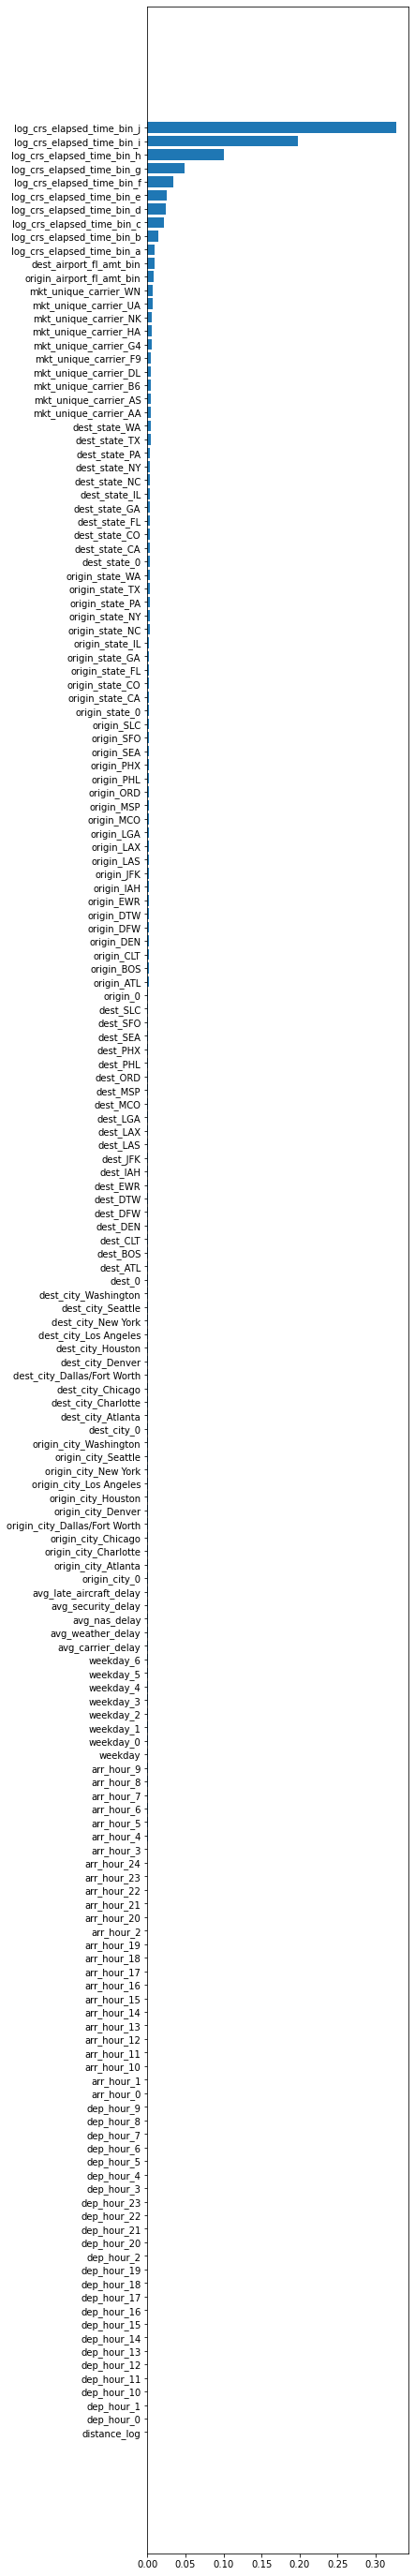

In [296]:
plt.figure(figsize=(5, 50))
plt.barh(y=X.columns, width=pca.explained_variance_ratio_);

In [308]:
np.cumsum(pca.explained_variance_ratio_) < 0.40

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,

### XGBOOST

In [343]:
# XGboost model
import xgboost as xgb
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

y = df.arr_delay.to_numpy()
X = df.drop(columns=['arr_delay']).to_numpy()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)
data_dmatrix = xgb.DMatrix(data=X_train,label=y_train)

xgb = xgb.XGBRegressor(learning_rate = 1.1,
                       max_depth = 6, 
                       alpha = 51, 
                       n_estimators = 20, 
                       n_jobs=-1, 
                       )

xgb.fit(X_train, y_train)
y_pred = xgb.predict(X_test)
print(f'MSE: {mean_squared_error(y_test, y_pred)}', f'R2: {r2_score(y_test, y_pred)}')

MSE: 267.2912702715599 R2: 0.09046366009705165


In [345]:
# Grid Search for XBBoost
# DON'T RUN
from sklearn.model_selection import GridSearchCV
# import xgboost as xgb
from xgboost import XGBRegressor

y = df.arr_delay.to_numpy()
X = df.drop(columns=['arr_delay']).to_numpy()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
xgb = XGBRegressor()

params = {
    'learning_rate': np.arange(0.5, 1.5, 0.1),
    'max_depth': np.arange(5, 9, 1),
    'reg_alpha': np.arange(10, 20, 5),
    'n_estimators': np.arange(15, 25, 5),
    'colsample_bytree': np.arange(0.3, 0.5, 0.1),
    'gamma': np.arange(5, 10, 3)
}

xgb_grid_search = GridSearchCV(xgb, 
                               param_grid=params, 
                               cv=5, 
                               n_jobs=-1, 
                               error_score='raise', 
                               verbose=True)
xgb_grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 640 candidates, totalling 3200 fits


GridSearchCV(cv=5, error_score='raise',
             estimator=XGBRegressor(base_score=None, booster=None,
                                    colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, gamma=None,
                                    gpu_id=None, importance_type='gain',
                                    interaction_constraints=None,
                                    learning_rate=None, max_delta_step=None,
                                    max_depth=None, min_child_weight=None,
                                    missing=nan, monotone_constraints=None,
                                    n_es...
                                    reg_alpha=None, reg_lambda=None,
                                    scale_pos_weight=None, subsample=None,
                                    tree_method=None, validate_parameters=None,
                                    verbosity=None),
             n_

In [ ]:
grid_search.best_score_

### SVM 

In [347]:
# Grid Search for estimator SVM
import xgboost as xgb
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR

y = df.arr_delay.to_numpy()
X = df.drop(columns=['arr_delay']).to_numpy()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

svm = svm.SVR()

params = {
    'C': np.arange(1, 2.5, 0.1),
    'probability': [True, False],
}

svm_grid_search = GridSearchCV(svm, 
                           param_grid=params, 
                           cv=5, 
                           n_jobs=-1, 
                           error_score='raise', 
                           verbose=True)
svm_grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 150 candidates, totalling 750 fits


C:\Users\jacky\anaconda3\envs\bootcamp\lib\site-packages\joblib\externals\loky\process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


ValueError: Invalid parameter probabilitybool for estimator SVC(degree=2). Check the list of available parameters with `estimator.get_params().keys()`.

In [ ]:
# svm model
from sklearn.smv import SVR
from sklearn.metrics import mean_squared_error, r2_score

#Create a svm Classifier
svm_reg = SVR(verbose=True)

#Train the model using the training sets
svm_reg.fit(X_train, y_train)

#Predict the response for test dataset
y_pred = svm_reg.predict(X_test)
print(f'MSE: {mean_squared_error(y_test, y_pred)}', f'R2: {r2_score(y_test, y_pred)}')

[LibSVM]